## Stage 1: Exploratory Data Analysis

# Setup & Data Loading

In [278]:
# Import needed packages
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import skew, kurtosis

In [279]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [280]:
# Set the theme and figisze for a unique plot appearence
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Data Preparation & simple Feature Engineering

In [281]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

# Convert the string representations of the lists to the correct 'list' datatype
cleaned_data['word_tokens'] = cleaned_data['word_tokens'].apply(string_to_list)
cleaned_data['sentence_tokens'] = cleaned_data['sentence_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_word_tokens'] = cleaned_data['pos_tagged_word_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_sentence_tokens'] = cleaned_data['pos_tagged_sentence_tokens'].apply(string_to_list)
cleaned_data['esg_topics'] = cleaned_data['esg_topics'].apply(string_to_list)

In [282]:
# Add some count features for the analysis
cleaned_data['cnt_word'] = cleaned_data['word_tokens'].apply(len)
cleaned_data['cnt_sentence'] = cleaned_data['sentence_tokens'].apply(len)
cleaned_data['cnt_esg'] = cleaned_data['esg_topics'].apply(len)

# Calculate ratio between words/sentences
cleaned_data['ratio_word_sentence'] = cleaned_data['cnt_word'] / cleaned_data['cnt_sentence']

In [283]:
# Convert date to correct datatype
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Derive year and month to aggregate
cleaned_data['year_month'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y-%m'))
cleaned_data['year'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y'))
cleaned_data['month'] = cleaned_data['date'].apply(lambda x: x.strftime('%m'))

In [284]:
# Check the data with a few samples
cleaned_data.sample(5)

company datatype       date         domain   
243               Adidas  general 2021-01-22    sneakernews  \
5634   Heidelberg Cement  general 2022-11-09   pumps-africa   
4618       Deutsche Post  general 2022-12-05  financialpost   
10682         Volkswagen  general 2021-07-08       autonews   
6932               Merck  general 2022-06-30       biospace   

                                        esg_topics  internal symbol   
243                                       [Social]         0    ADS  \
5634                               [CarbonDioxide]         0    HEI   
4618   [EMobility, RussianFederation, FossilFuels]         0    DPW   
10682                 [CustomerService, EMobility]         0   VOW3   
6932                                [HumanCapital]         0    MRK   

                                                   title   
243    The Simpsons adidas ZX 10.000C Krusty Burger H...  \
5634   Intro, Suez Cement ink PPA deal for 20 MWp sol...   
4618   GM converts plant to Canada's first full-scale...   
10682  Tesla unveils cheaper Model Y crossover in Chi...   
6932   AstraZeneca Touts China Expansion, Positive CH...   

                                         cleaned_content   
243    advertisement " aurora borealis. at this time ...  \
5634     scgc  with a 20 mwp solar power plant. the t...   
4618   . plant in ingersoll, ont., that has been maki...   
10682  . debuted a significantly cheaper version of i...   
6932   , with progress being shown in china, positive...   

                                             word_tokens  ...   
243    [advertisement, aurora, borealis, time, time, ...  ...  \
5634   [scgc, mwp, solar, power, plant, two, inked, p...  ...   
4618   [plant, ingersoll, ont, ha, making, gas, power...  ...   
10682  [debuted, significantly, cheaper, version, loc...  ...   
6932   [progress, shown, china, positive, recommendat...  ...   

                       sector                                industry   
243    Consumer Discretionary                  Footwear & Accessories  \
5634          Basic Materials                      Building Materials   
4618              Industrials          Integrated Freight & Logistics   
10682  Consumer Discretionary                      Auto Manufacturers   
6932               Healthcare  Drug Manufacturers—Specialty & Generic   

      sentiment_value  cnt_word cnt_sentence cnt_esg  ratio_word_sentence   
243            0.8732       169           10       1            16.900000  \
5634           0.8211       136            8       1            17.000000   
4618           0.9948       420           31       3            13.548387   
10682          0.9789       486           37       2            13.135135   
6932           0.8151       337           22       1            15.318182   

       year_month  year  month  
243       2021-01  2021     01  
5634      2022-11  2022     11  
4618      2022-12  2022     12  
10682     2021-07  2021     07  
6932      2022-06  2022     06  

[5 rows x 24 columns]

# General Descriptive Analysis

In [285]:
# Define a function to plot histograms and boxplots
def plot_basic_hist_and_box(column, data):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# Calculate measures of central tendency, skewness, and kurtosis
def calculate_basic_statistical_properties(column, data):
    mean = data[column].mean()
    median = data[column].median()
    mode = data[column].mode().values[0]
    skewness = skew(data[column].dropna())
    kurt = kurtosis(data[column].dropna())
    
    print(f'Mean: {round(mean,2)}\nMedian: {round(median,2)}\nMode: {round(mode,2)}\nSkewness: {round(skewness,2)}\nKurtosis: {round(kurt,2)}')

# Measures of dispersion (range, interquartile range, variance, and standard deviation)
def calulate_dispersion_measures(column, data):
    min_value = data[column].min()
    max_value = data[column].max()
    range_value = max_value - min_value
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    variance = data[column].var()
    std_dev = data[column].std()
    
    print(f'Range: {round(range_value,2)}\nInterquartile Range: {round(iqr,2)}\nVariance: {round(variance,2)}\nStandard Deviation: {round(std_dev,2)}')

### Basic Statistical Metrics of Reports by Words

Mean: 956.1
Median: 342.0
Mode: 208
Skewness: 13.78
Kurtosis: 224.27
Range: 127305
Interquartile Range: 338.0
Variance: 25012182.46
Standard Deviation: 5001.22


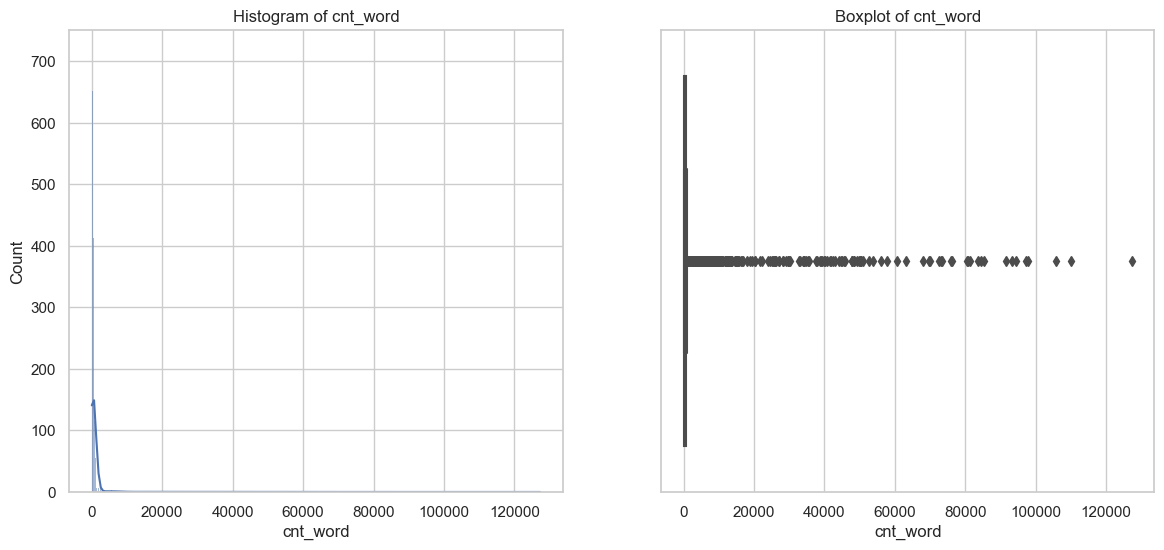

In [286]:
calculate_basic_statistical_properties('cnt_word', cleaned_data)
calulate_dispersion_measures('cnt_word', cleaned_data)
plot_basic_hist_and_box('cnt_word', cleaned_data)

Mean: 64.32
Median: 24.0
Mode: 12
Skewness: 13.83
Kurtosis: 231.13
Range: 8268
Interquartile Range: 26.0
Variance: 101432.22
Standard Deviation: 318.48


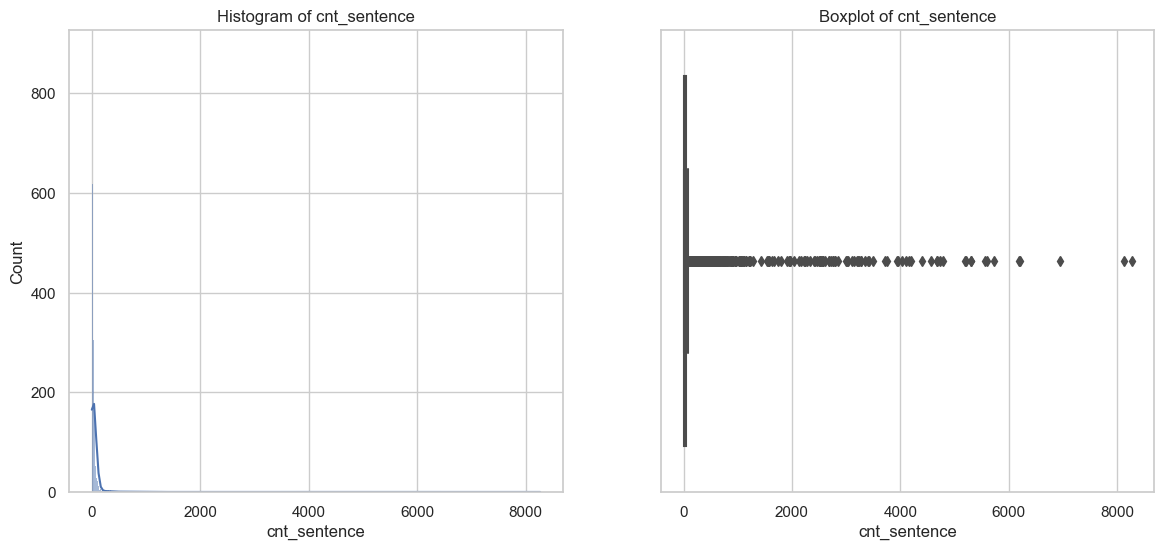

In [287]:
calculate_basic_statistical_properties('cnt_sentence', cleaned_data)
calulate_dispersion_measures('cnt_sentence', cleaned_data)
plot_basic_hist_and_box('cnt_sentence', cleaned_data)

Mean: 597.25
Median: 340.0
Mode: 208
Skewness: 17.15
Kurtosis: 425.48
Range: 63205
Interquartile Range: 332.0
Variance: 2966233.27
Standard Deviation: 1722.28


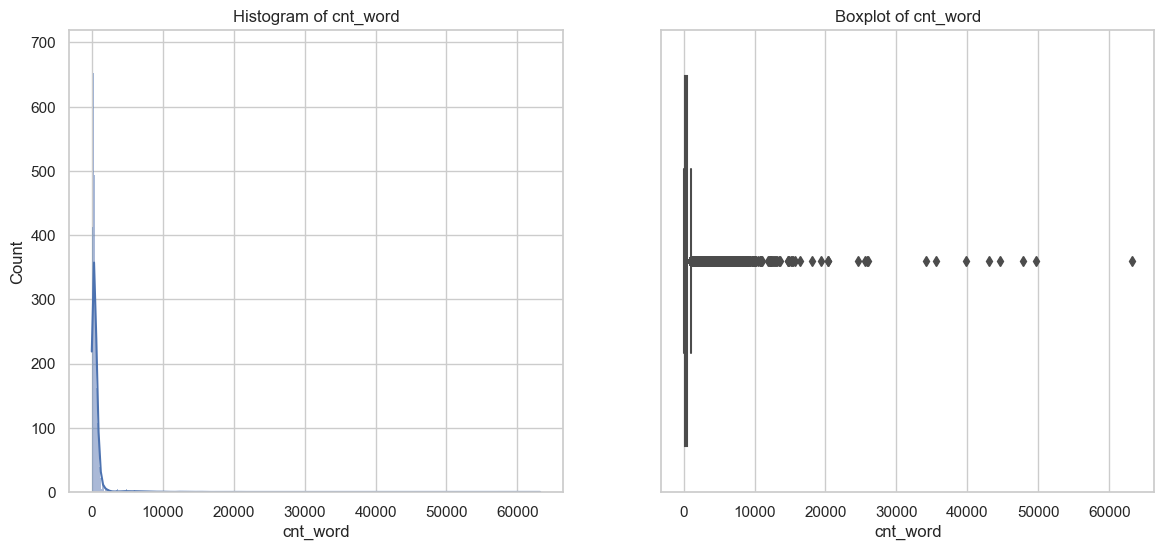

In [288]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 0])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 0])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 0])

Mean: 44263.02
Median: 39235.0
Mode: 2385
Skewness: 0.67
Kurtosis: -0.16
Range: 124920
Interquartile Range: 33849.0
Variance: 803099011.2
Standard Deviation: 28339.0


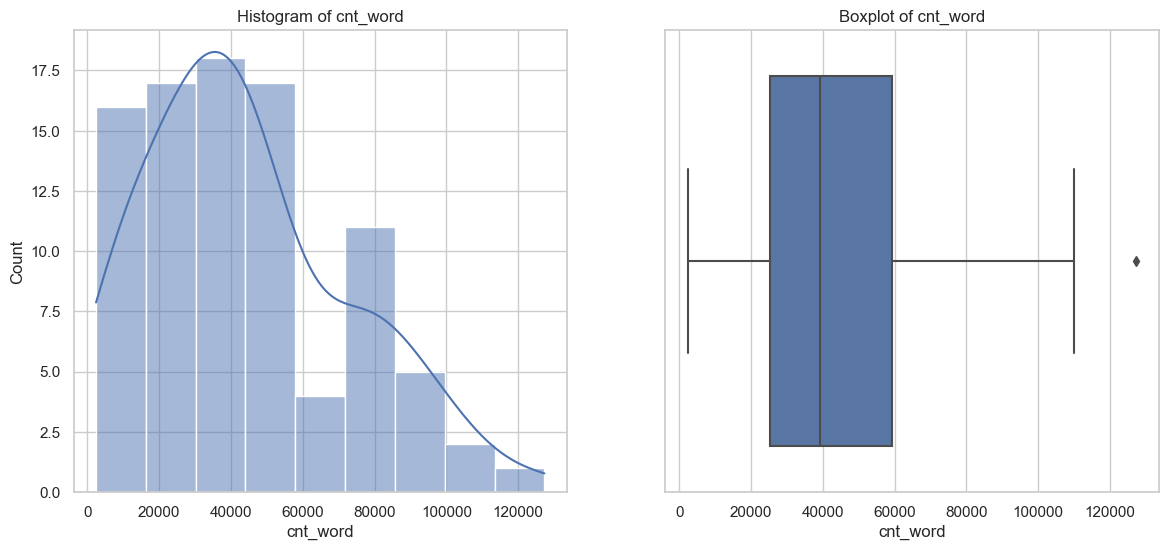

In [289]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 1])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 1])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 1])

# Text Specific Analysis

### Datatype (Report Type) Amount

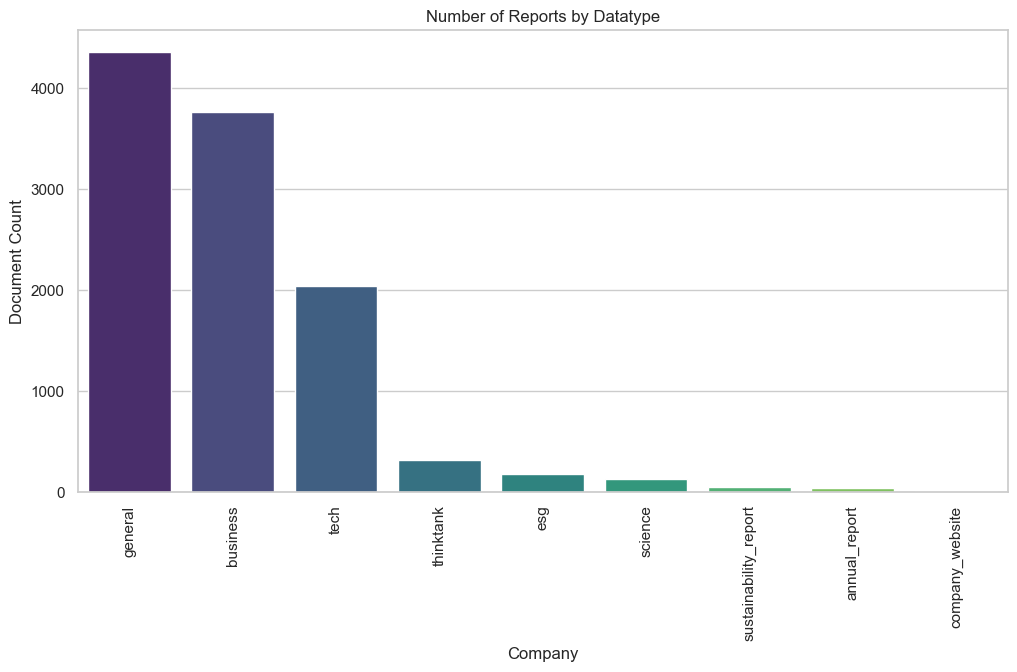

In [290]:
count_datatype = cleaned_data['datatype'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Number of Reports by Datatype')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

### Number of Reports by Company

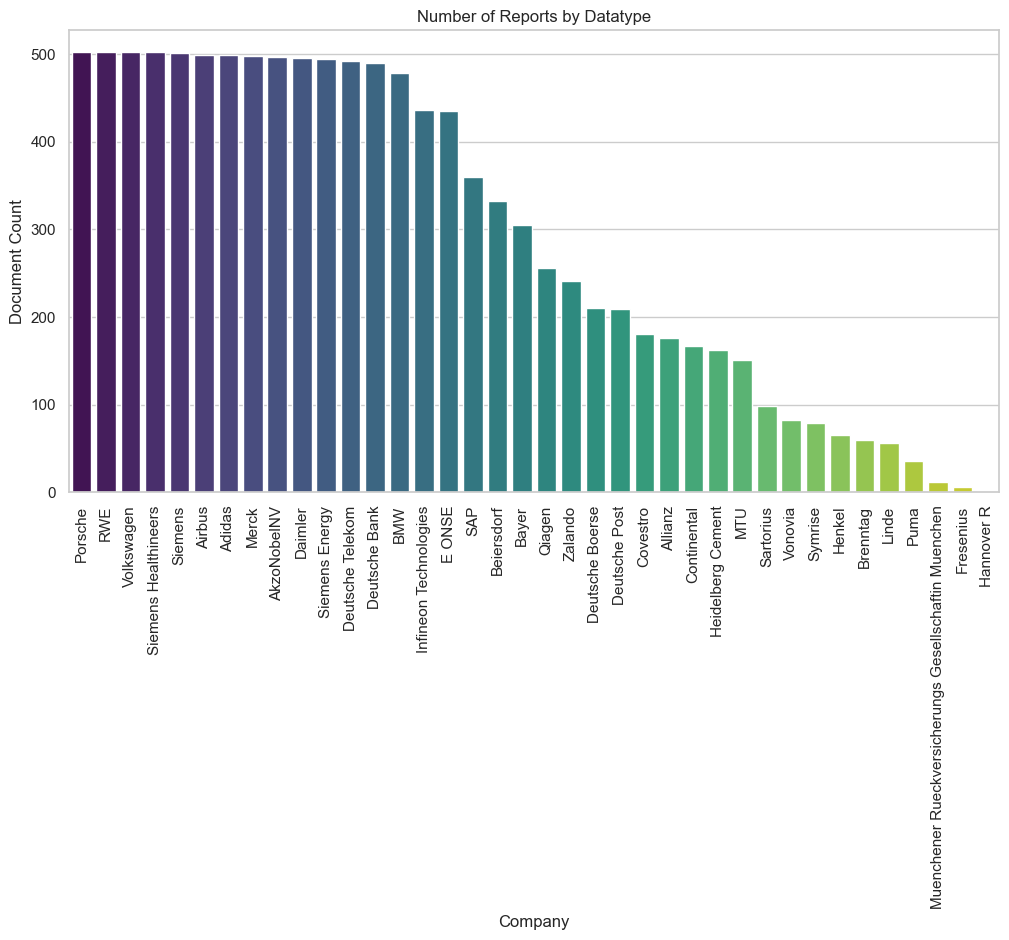

In [291]:
count_datatype = cleaned_data['company'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Number of Reports by Datatype')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

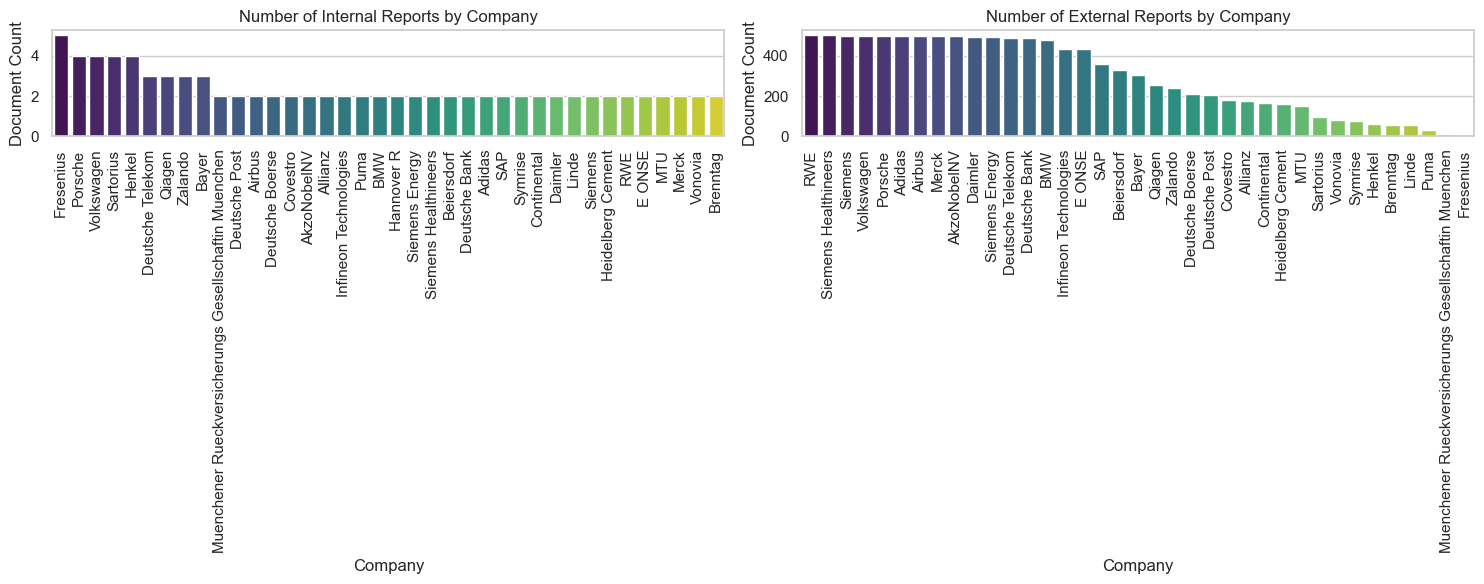

In [292]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data['company'].value_counts()
count_external_datatype = external_data['company'].value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=count_internal_datatype.index, y=count_internal_datatype.values, palette='viridis')
plt.title('Number of Internal Reports by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=count_external_datatype.index, y=count_external_datatype.values, palette='viridis')
plt.title('Number of External Reports by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Internal vs. External Report

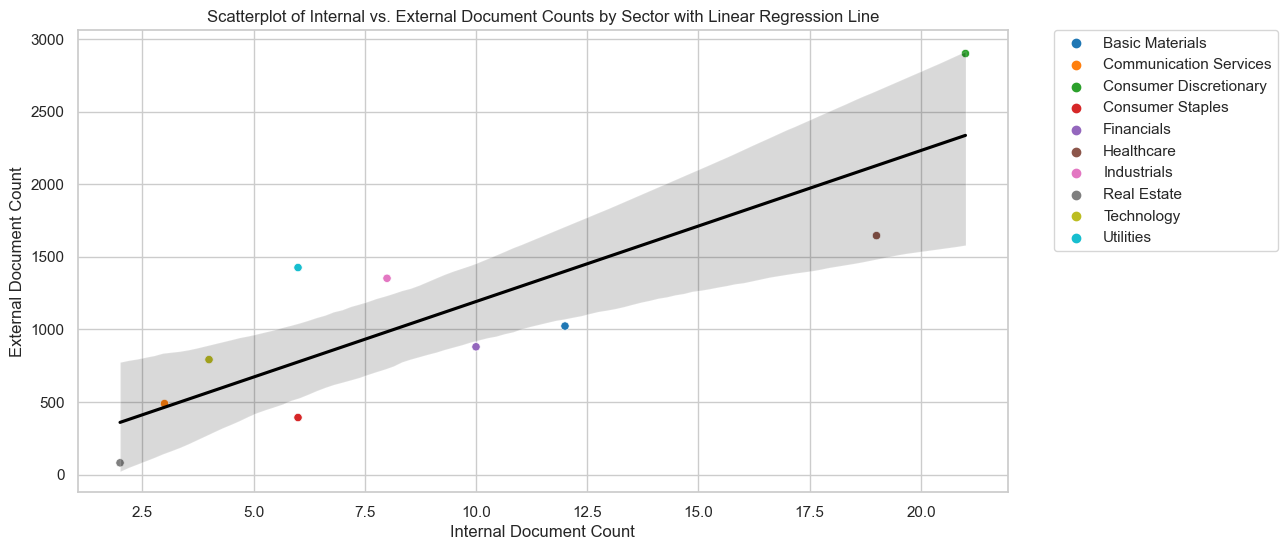

In [293]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data.groupby('sector')['company'].count()
count_external_datatype = external_data.groupby('sector')['company'].count()

# Create a new DataFrame with internal and external document counts for each sector
doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_count', y='external_count', hue='sector', palette='tab10')
sns.regplot(data=doc_counts, x='internal_count', y='external_count', scatter=False, color='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Internal vs. External Document Counts by Sector with Linear Regression Line')
plt.xlabel('Internal Document Count')
plt.ylabel('External Document Count')
plt.show()

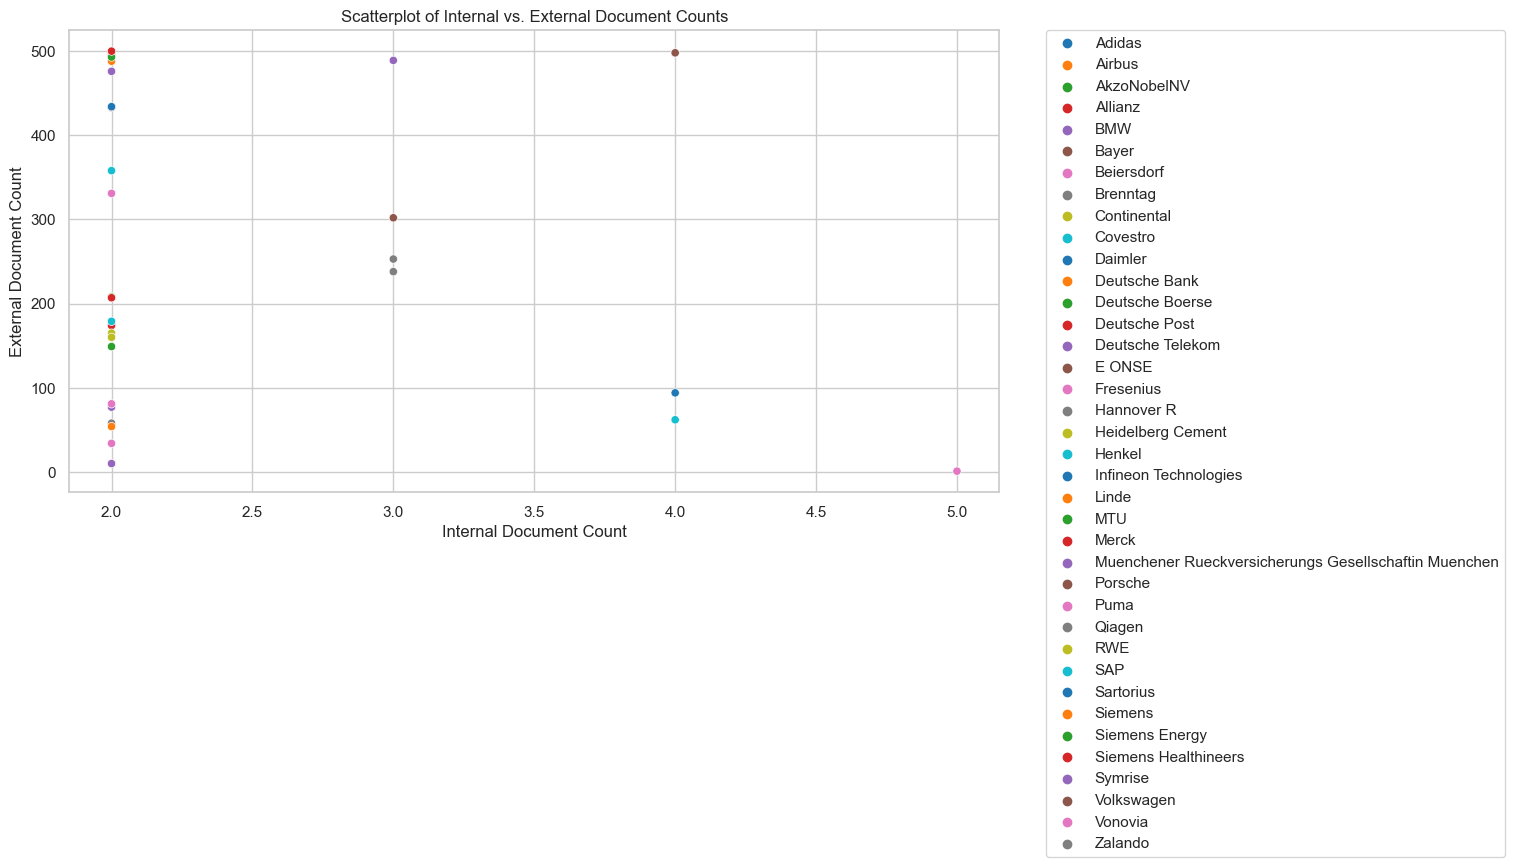

In [294]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

# Calculate value counts for each subset
count_internal_datatype = internal_data['company'].value_counts()
count_external_datatype = external_data['company'].value_counts()

# Create a new DataFrame with internal and external document counts for each company
doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index().rename(columns={'index': 'company'})

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_count', y='external_count', hue='company', palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Internal vs. External Document Counts')
plt.xlabel('Internal Document Count')
plt.ylabel('External Document Count')
plt.show()

### Characteristic Words by Company

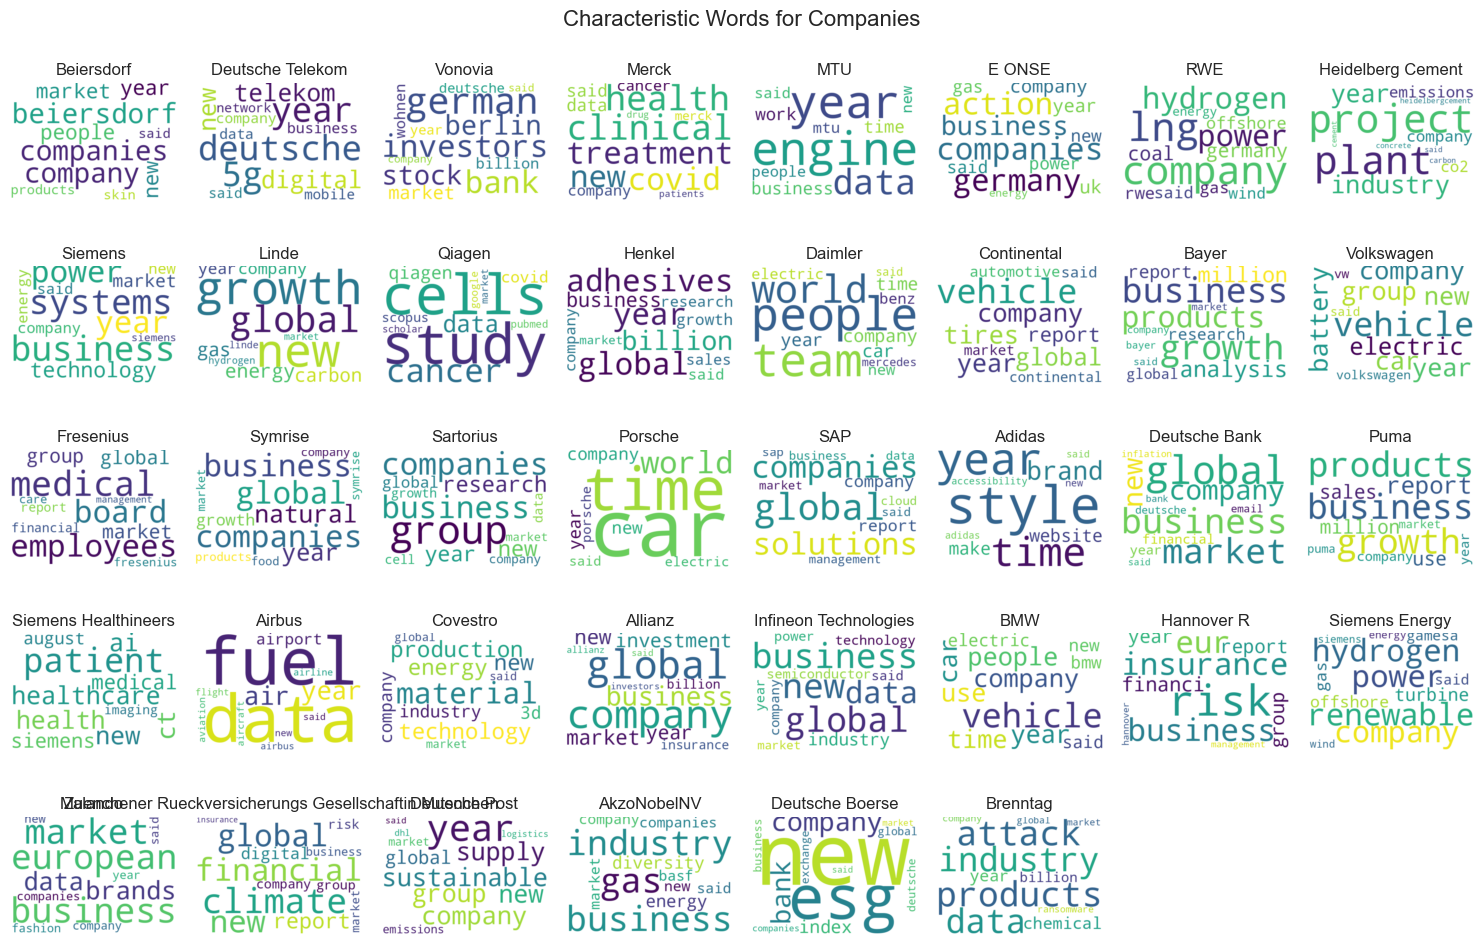

In [295]:
def characteristic_words_by_company(company, data, n=12):
    company_data = data[data['company'] == company]
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(company_data['cleaned_content'])
    top_n_indices = np.argsort(X.toarray().sum(axis=0))[-n:]
    top_n_words = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    return top_n_words

companies = cleaned_data['company'].unique()
for company in companies:
    characteristic_words = characteristic_words_by_company(company, cleaned_data)
    # print(f'{company}: {', '.join(characteristic_words)}')

def plot_wordcloud_subplot(ax, company, data, n=12):
    characteristic_words = characteristic_words_by_company(company, data, n)
    wordcloud = WordCloud(width=500, height=350, background_color='white', colormap='viridis').generate(' '.join(characteristic_words))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{company}')

companies = cleaned_data['company'].unique()
n_companies = len(companies)

fig, axes = plt.subplots(nrows=int(np.ceil(n_companies/8)), ncols=8, figsize=(15, 10))
axes = axes.ravel()

for i, company in enumerate(companies):
    plot_wordcloud_subplot(axes[i], company, cleaned_data)

for i in range(n_companies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Characteristic Words for Companies', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0) # Adjust the horizontal and vertical spacing between subplots
plt.tight_layout()
plt.show()

# Timeseries Analysis

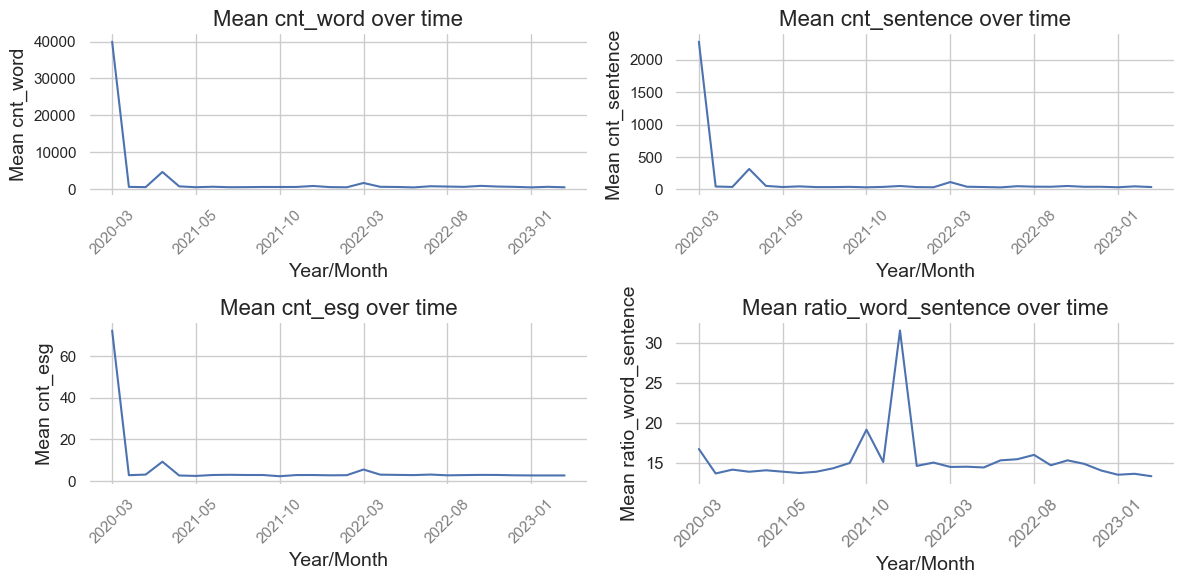

In [296]:
sns.set(style='whitegrid')

def plot_time_series(data, column, groupby_column=None, title=None, ylabel=None, start='2020-03', end='2023-03', agg_func=np.mean, ax=None, show=True):
    # Filter data based on the start and end dates
    if start:
        data = data[data['year_month'] >= start]
    if end:
        data = data[data['year_month'] <= end]

    if groupby_column:
        grouped_data = data.groupby(['year_month', groupby_column])[column].agg(agg_func).unstack()
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))
        ax.legend(title=groupby_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        grouped_data = data.groupby('year_month')[column].agg(agg_func)
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))

    # Customize the plot's aesthetics
    ax.set_title(title or f'{agg_func.__name__.capitalize()} {column} over time', fontsize=16)
    ax.set_xlabel('Year/Month', fontsize=14)
    ax.set_ylabel(ylabel or f'{agg_func.__name__.capitalize()} {column}', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_color('grey')
    plt.yticks(fontsize=12)
    sns.despine(left=True, bottom=True)

    if show:
        plt.tight_layout()
        plt.show()


fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

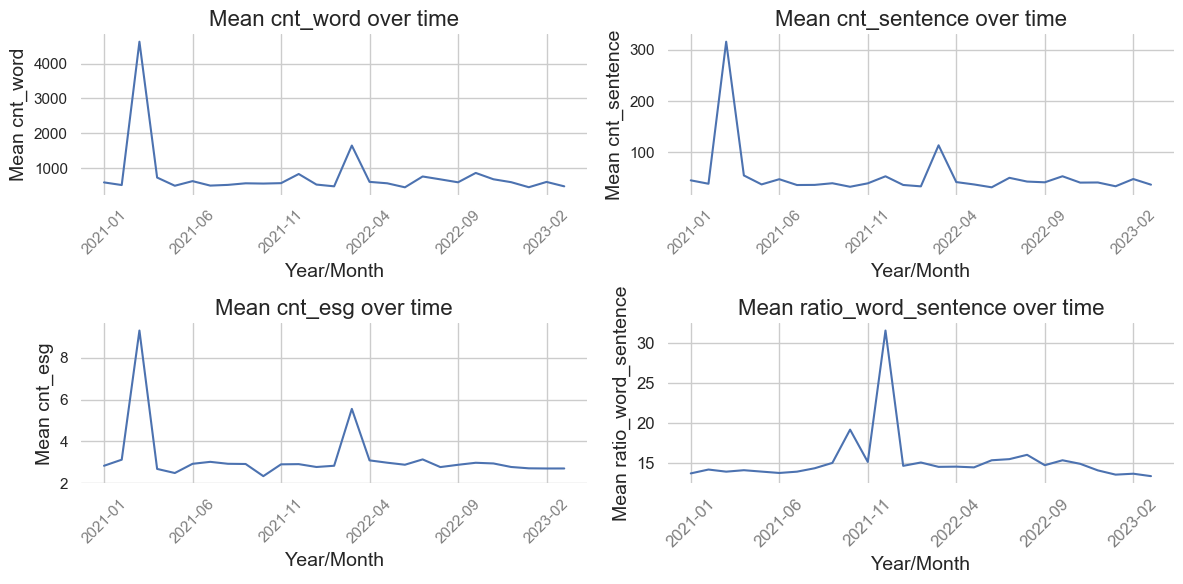

In [297]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', start='2020-05', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', start='2020-05', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', start='2020-05', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', start='2020-05', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

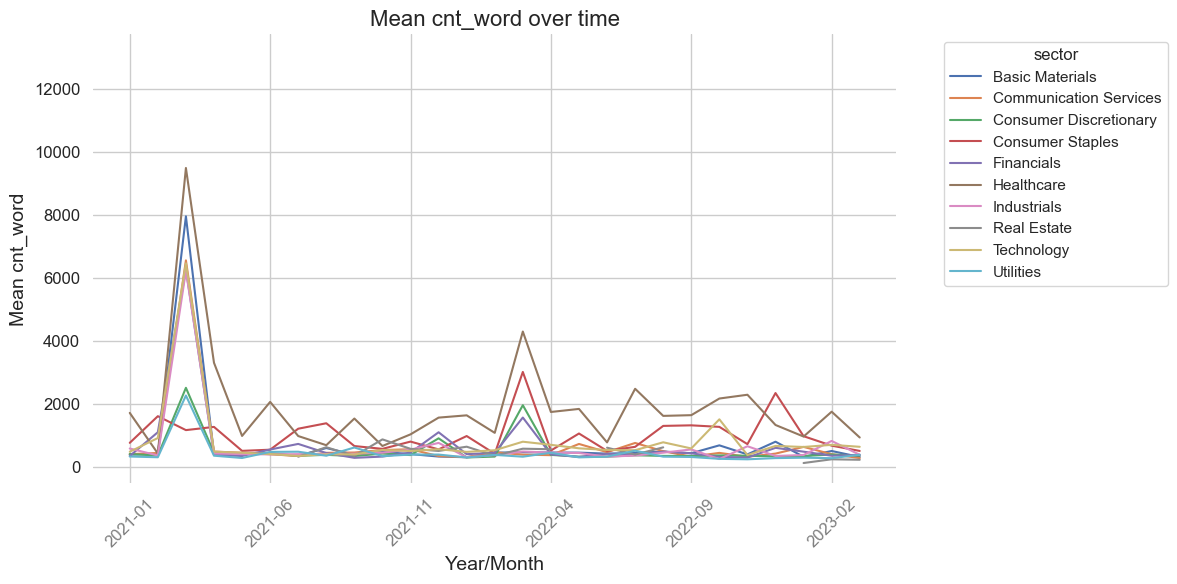

In [298]:
# Average 'cnt_word' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_word', 'sector', start='2020-05',show=True)

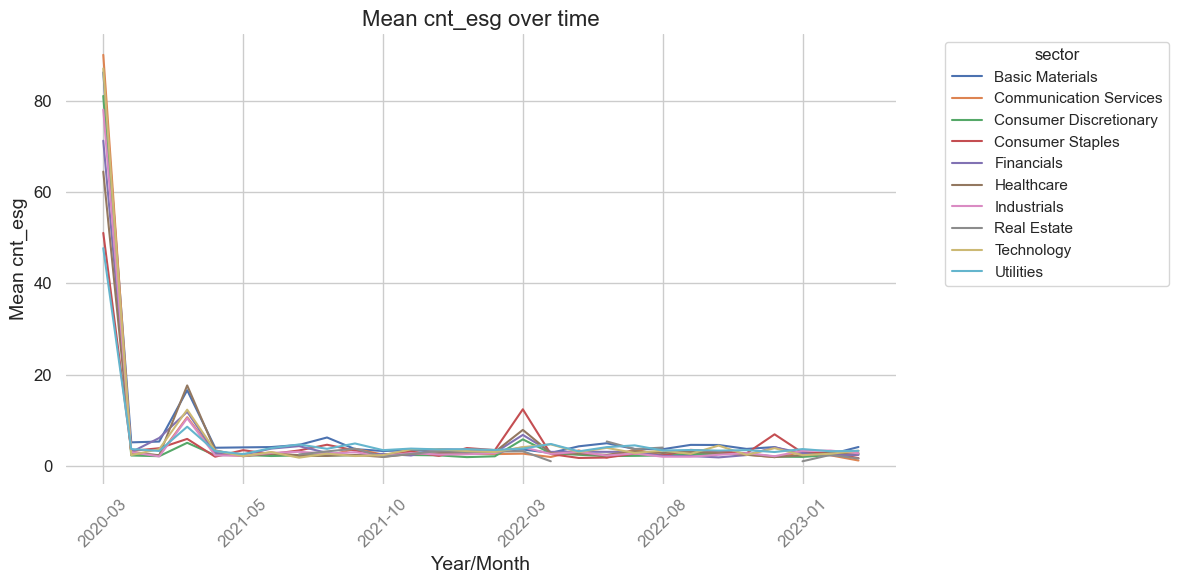

In [299]:
# Average 'cnt_esg' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_esg', 'sector')

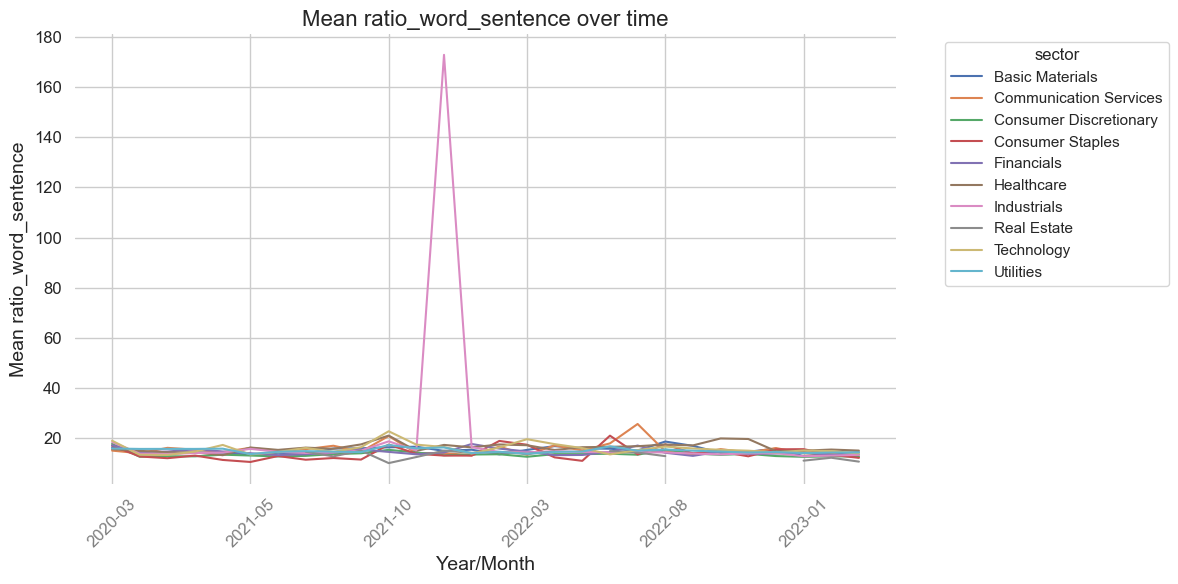

In [300]:
# Average 'ratio_word_sentence' over time by 'sector'
plot_time_series(cleaned_data, 'ratio_word_sentence', 'sector')

## Sector & Industry Analysis

In [320]:
cleaned_data.sample(5)

company  datatype       date             domain   
10868            Zalando   general 2022-01-26       businesswire  \
650               Airbus      tech 2021-04-02     digitaljournal   
6877               Merck      tech 2022-01-14  securityboulevard   
162               Adidas       NaN 2021-10-04        vegconomist   
5677   Heidelberg Cement  business 2022-11-02     investmentweek   

                                              esg_topics  internal symbol   
10868              [ConsumerBehavior, RussianFederation]         0    ZAL  \
650    [WorkerCrisis, terrorism, RenewableEnergy, Fos...         0    AIR   
6877                             [Cybersecurity, Social]         0    MRK   
162    [PlantBasedLeather, Environment, Social, Susta...         0    ADS   
5677   [CustomerService, Pollution, Environment, AirP...         0    HEI   

                                                   title   
10868  Europe B2C E-Commerce Market 2022, Featuring A...  \
650    EgyptAir black boxes impossible to recover bef...   
6877   Tackling the rise of cyber-attacks on Industri...   
162    Global Sustainable Clothing Market Outlook: Ra...   
5677   Investor warning for air polluting sector returns   

                                         cleaned_content   
10868  dublin      business wire     the    europe b2...  \
650    hi, what are you looking for? by published inv...   
6877   cyber attacks on industrial control systems ar...   
162    dublin    business wire   the " global sustain...   
5677   . if you already have an account please use th...   

                                             word_tokens  ...   
10868  [dublin, business, wire, europe, b2c, e, comme...  ...  \
650    [hi, looking, published, investigator, egyptai...  ...   
6877   [cyber, attack, industrial, control, system, i...  ...   
162    [dublin, business, wire, global, sustainable, ...  ...   
5677   [already, account, please, use, link, sign, pr...  ...   

                       sector                                industry   
10868  Consumer Discretionary                         Internet Retail  \
650               Industrials                     Aerospace & Defense   
6877               Healthcare  Drug Manufacturers—Specialty & Generic   
162    Consumer Discretionary                  Footwear & Accessories   
5677          Basic Materials                      Building Materials   

      sentiment_value  cnt_word cnt_sentence cnt_esg  ratio_word_sentence   
10868          0.9940       358           16       2            22.375000  \
650           -0.2561       603           46       5            13.108696   
6877          -0.9944       563           40       2            14.075000   
162            0.9953       446           22       9            20.272727   
5677          -0.7453       260           22       6            11.818182   

       year_month  year  month  
10868     2022-01  2022     01  
650       2021-04  2021     04  
6877      2022-01  2022     01  
162       2021-10  2021     10  
5677      2022-11  2022     11  

[5 rows x 24 columns]

# Sentiment Analysis / Polarity

# Word Embedding Visualization with Word2Vec

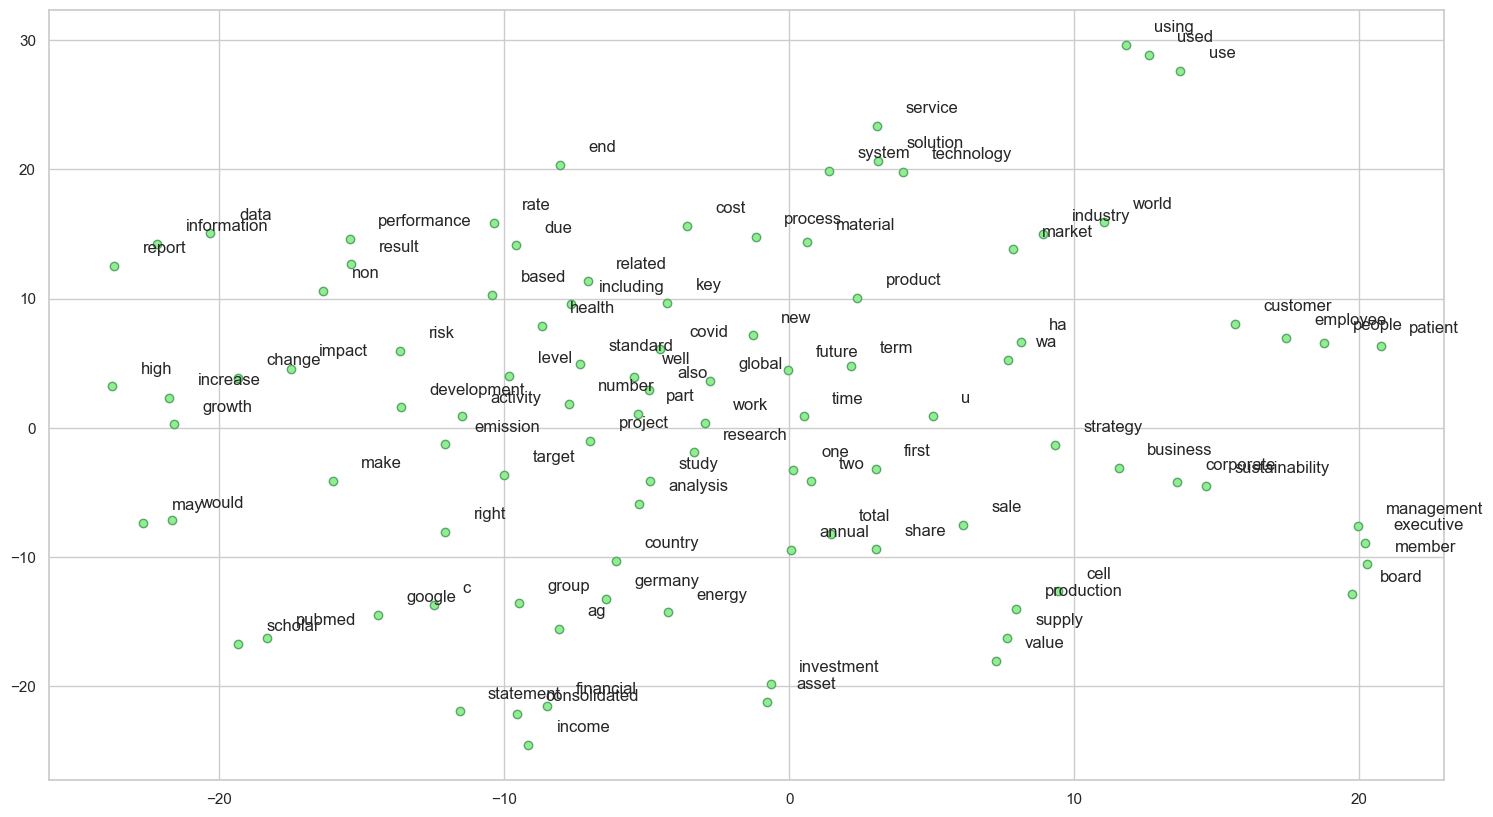

In [302]:
all_words = [word for word_list in cleaned_data['word_tokens'] for word in word_list]

# Count the occurrences of each word and find the top 100 words
word_counts = Counter(all_words)
top_100_words = [word for word, _ in word_counts.most_common(100)]

# Train a Word2Vec model on the combined words with a fixed seed (42 is always the answer)
w2vmodel = Word2Vec(cleaned_data['word_tokens'], vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Get the embeddings of the top 100 words
wvs = w2vmodel.wv[top_100_words]

# Use t-SNE to reduce the dimensions of the embeddings with a fixed seed
tsne = TSNE(n_components=2, random_state=42, n_iter=10000, perplexity=5)
T = tsne.fit_transform(wvs)
labels = top_100_words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

plt.show()

## ESG Topic Exploration

### ESG Topic Distribution over Time

/var/folders/9k/tdnv785s1hx8x68mq3f94lzw0000gn/T/ipykernel_99806/3729081898.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


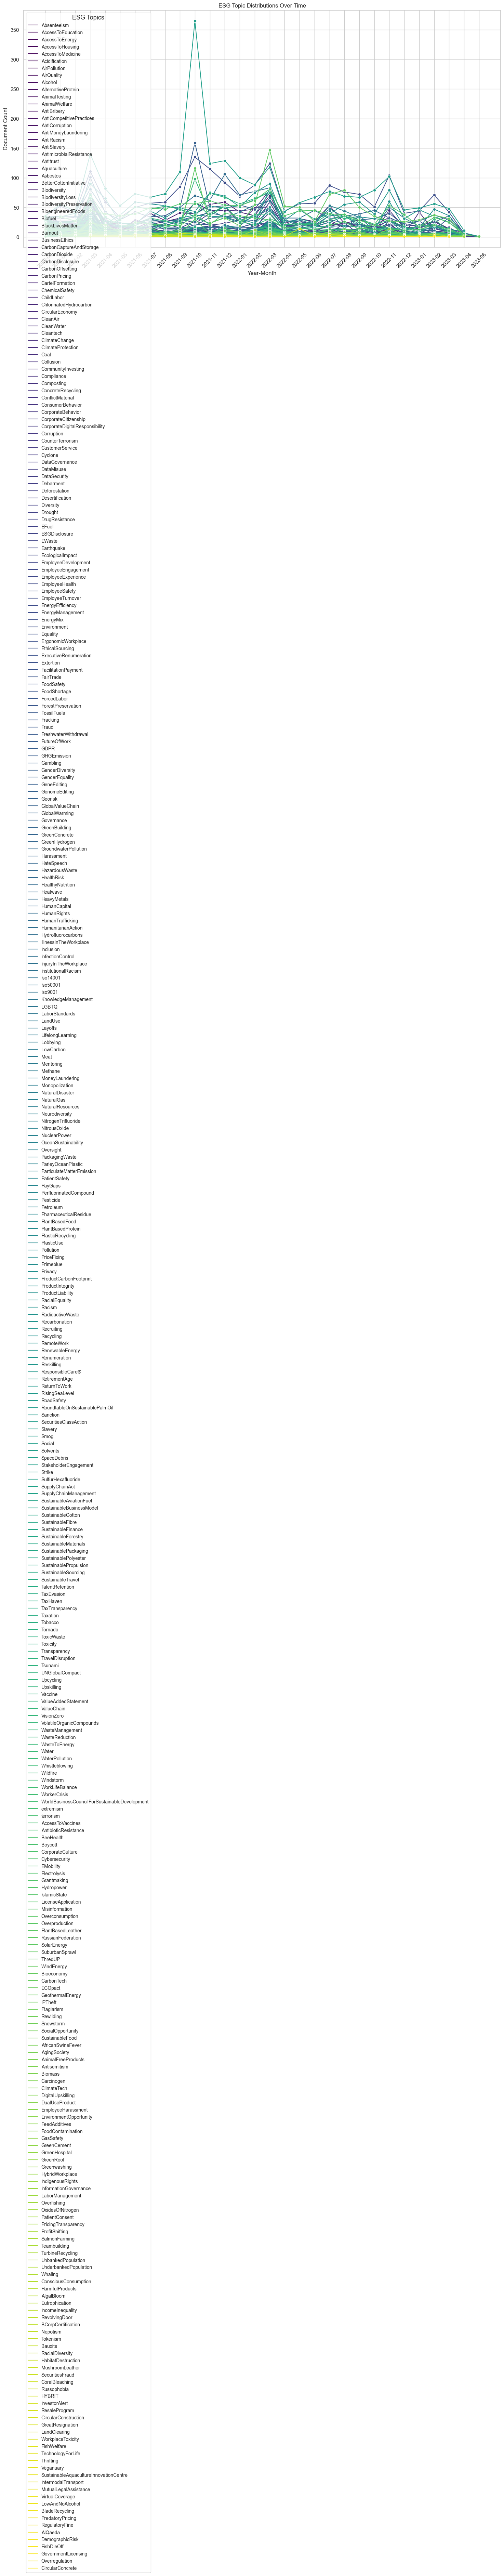

In [303]:
topic_timeseries = cleaned_data.explode('esg_topics').groupby(['year_month', 'esg_topics']).size().reset_index(name='count')

plt.figure(figsize=(18, 9))
sns.lineplot(data=topic_timeseries, x='year_month', y='count', hue='esg_topics', marker='o', palette='viridis')
plt.title('ESG Topic Distributions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.legend(title='ESG Topics', title_fontsize='13', loc='upper left', fontsize='10')
plt.tight_layout()
plt.show()